<a href="https://colab.research.google.com/github/hyd3nekosuki/RPDsummer2024/blob/main/1DSlabMOC2024RPDsmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from scipy.special import eval_legendre
from numba import njit

In [2]:
# Nambaを利用したtranport sweep
@njit(cache=True)
def transportSweep(psiSBefore, SigT, q, dx, matid, albedo, w, mu):
    NX = len(q)
    NM = len(w)

    flux      = np.zeros(NX)                # メッシュ平均の全中性子束
    fluxS     = np.zeros(NX+1)              # 境界面平均の全中性子束
    J         = np.zeros(NX+1)              # 境界面平均の全中性子流
    psiS      = np.zeros_like( psiSBefore ) # 境界面の流出角度中性子束

    for m in range(NM):
        wm  = w[m]
        mum = mu[m]
        abs_mum = np.abs(mum)
        psiSm       = psiS[m,:]

        if mu[m] > 0.0:
            startX= 0
            endX  = NX
            signX = +1
            delta_iIn = 0
            delta_iOut = 1
            psiin  = psiSBefore[NM-1-m, 0] * albedo[0]  # albedo boundary
            psiSm[0]  = psiin
            fluxS[0]  += wm*psiin
            J[0]      += wm*mum*psiin
        else:
            startX= NX-1
            endX  = -1
            signX = -1
            delta_iIn = 1
            delta_iOut = 0
            psiin  = psiSBefore[NM-1-m, -1] * albedo[1] # albedo boundary
            psiSm[-1]  = psiin
            fluxS[-1]  += wm*psiin
            J[-1]      += wm*mum*psiin

        for i in range(startX, endX, signX):
            iin  = i+delta_iIn
            iout = i+delta_iOut

            SigT0 = SigT[matid[i]]
            dx0   = dx[i]
            ell   = dx0/abs_mum
            tau   = SigT0*ell

            if SigT0 == 0:
                psiout = psiin + q[i]*ell
                psiave = (psiin + psiout)/2
            else:
                exptaum = np.exp(-tau)
                psiout = psiin*exptaum + q[i]*(1-exptaum) / SigT0
                psiave = ( q[i] - (psiout - psiin)/ell )  / SigT0

            flux[i]     += wm*psiave  # メッシュ平均の全中性子束計算
            fluxS[iout] += wm*psiout
            J[iout]     += wm*mum*psiout
            psiin = psiout
        psiS[m,delta_iOut] = psiout     # 外部流出境界面の角度中性子束

    return  flux, fluxS, J, psiS

In [3]:
@njit(cache=True)
def calcDcor(flux, J, D, dx, matid, albedo):
    NX = len(flux)
    JDx = np.zeros(NX+1)

    JDx[0]    = -(1-albedo[0])*D[0] /(2*(1+albedo[0])*D[0]  + (1-albedo[0])*dx[0]/2) *flux[0]
    JDx[1:-1] = -2*D[:-1]*D[1:]/(D[:-1]*dx[1:] + D[1:]*dx[:-1]) * (flux[1:]-flux[:-1])
    JDx[-1]   =  (1-albedo[1])*D[-1]/(2*(1+albedo[1])*D[-1] + (1-albedo[1])*dx[-1]/2)*flux[-1]

    Dcor = J - JDx
    Dcor[0]    /= flux[0]
    Dcor[1:-1] /= (flux[1:]+flux[:-1])
    Dcor[-1]   /= flux[-1]

    return Dcor

In [4]:
@njit(cache=True)
def diffusion1DX(D, Dcor, SigA, s, dx, matid, albedo):
    NX  = len(s)
    L   = np.zeros(NX)
    U   = np.zeros(NX)
    Axp = np.zeros(NX)

    for i in range(NX):
        D0  = D[i]
        dx0 = dx[i]
        if i==0:
            a = albedo[0]
            Dxm = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dm  = D[i-1]
            dxm = dx[i-1]
            Dxm = -2*Dm*D0/(Dm*dx0 + D0*dxm)
            Axm = (Dxm-Dcor[i])/dx0
        if i==(NX-1):
            a = albedo[1]
            Dxp = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dp  = D[i+1]
            dxp = dx[i+1]
            Dxp = -2*D0*Dp/(D0*dxp + Dp*dx0)
            Axp[i] = (Dxp+Dcor[i+1])/dx0

        A0 = SigA[matid[i]] - ( (Dxm+Dcor[i] + Dxp-Dcor[i+1])/dx0 )

        if i==0:
            L[i] = 0.0
            U[i] = A0
        else:
            L[i] = Axm/U[i-1]
            U[i] = A0 - Axp[i-1]*L[i]

    B = np.zeros(NX)
    BBefore = 0.0
    for i in range(NX):
        B[i] = s[i] - BBefore*L[i]
        BBefore = B[i]

    flux = np.zeros(NX)
    fluxAfter = 0.0
    for i in range(NX-1, -1, -1):
        fluxAfter = (B[i] - Axp[i]*fluxAfter) / U[i]
        flux[i] = fluxAfter

    return flux

In [5]:
def setQuadrature(NM, quadrature=None):
    if quadrature is None:
        quadrature = 1

    HalfNM= NM//2
    if HalfNM <= 0:
        HalfNM = 1
    NM = 2*HalfNM

    if quadrature == 1:
        mu, w, wsum= roots_legendre(NM, mu=True)
        mubound = np.zeros(NM+1)
        mubound[0]  = -1.0
        mubound[1:] = w.cumsum()-1.0
        mubound[NM] = 1.0
        mubound = ( mubound - mubound[::-1] )/2
    elif quadrature == 2:
        mu1, w1, wsum= roots_legendre(HalfNM, mu=True)
        mu = np.zeros(NM)
        w  = np.zeros(NM)
        mu[:HalfNM] = (mu1-1)/2
        mu[HalfNM:] = (mu1+1)/2
        w[:HalfNM] = w1/2
        w[HalfNM:] = w1/2
        mubound = np.zeros(NM+1)
        mubound[0]  = -1.0
        mubound[1:] = w.cumsum()-1.0
        mubound[NM] = 1.0
        mubound = ( mubound - mubound[::-1] )/2


    return NM, mu, mubound, w


In [6]:
@njit(cache=True)
def calcFluxMOC(SigS, SigA, s, dx, matid, albedo, w, mu, eps=None, outermax=None):
    if eps is None:
        eps = 1e-10
    if outermax is None:
        outermax = 1000
    NX = len(s)
    SigT = SigA+SigS
    D = 1/(3*SigT)
    Dagd = D[matid] + dx/4
    Dcor = np.zeros(NX+1)
    flux = diffusion1DX(Dagd, Dcor, SigA, s, dx, matid, albedo)

    psiS     = np.full( (NM, 2), 0.0 ) # 外部境界面の角度中性子束のみ保持
    psiS[mu>0, 0]  = 0
    psiS[mu<0, -1] = 0

    fluxBefore = flux.copy()
    for iter in range(1, outermax+1):
        q = (s + SigS[matid]*flux)/2
        flux, fluxS, J, psiS = transportSweep(psiS, SigT, q, dx, matid, albedo, w, mu)
        if np.all(flux>0) and iter%3==0:
            Dcor = calcDcor(flux, J, Dagd, dx, matid, albedo)
            factor=(diffusion1DX(Dagd, Dcor, SigA, s, dx, matid, albedo)) / flux
            if np.all(factor>0):
                flux *= factor

        relerr=np.abs(flux/fluxBefore - 1.0)
        relerr[relerr==np.inf]=1
        fluxBefore = flux.copy()
        if relerr.max() < eps:
            break

    #print("iteration = {0}, relative error max = {1}".format(iter, relerr.max()))
    #print(iter, relerr.max())
    return flux

In [7]:
def ordinal(i):
    j = i%100
    return "{}".format(i)+({1:"st", 2:"nd", 3:"rd"}.get(j if 14>j>10 else j % 10) or "th")

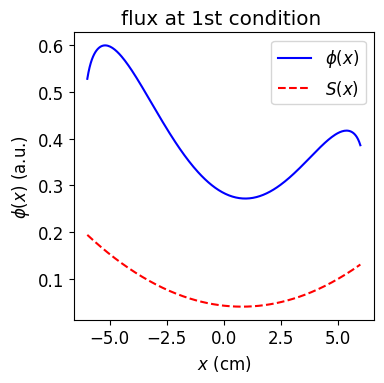

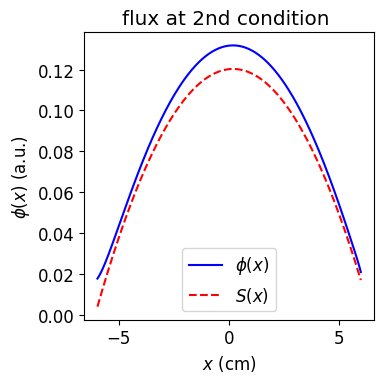

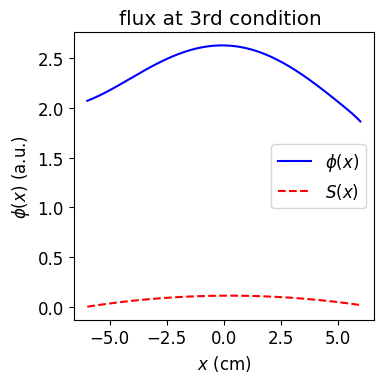

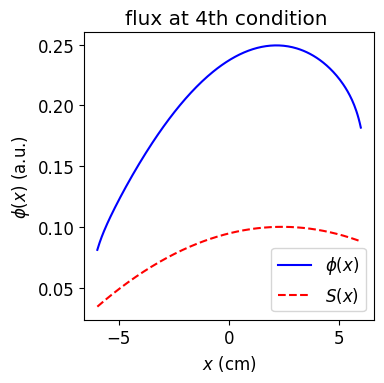

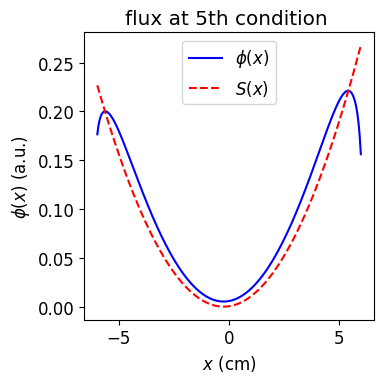

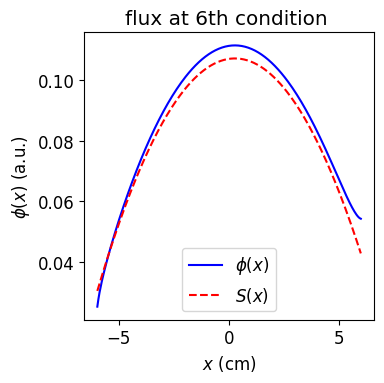

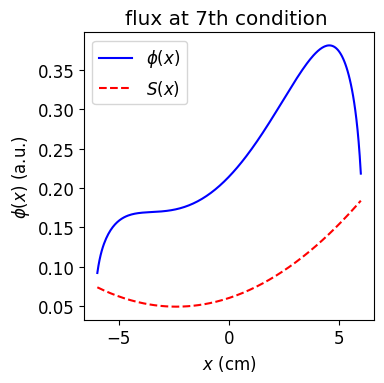

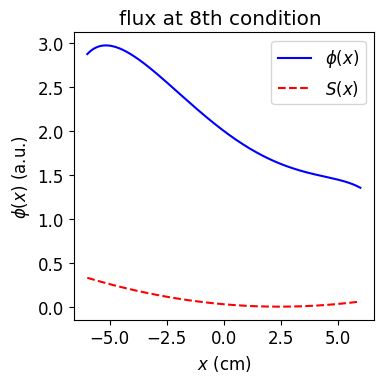

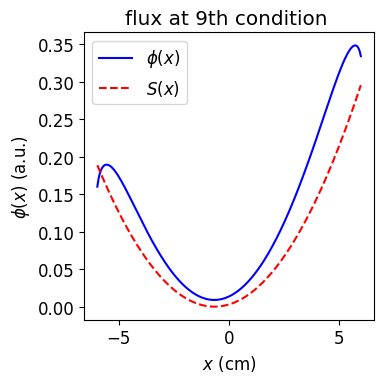

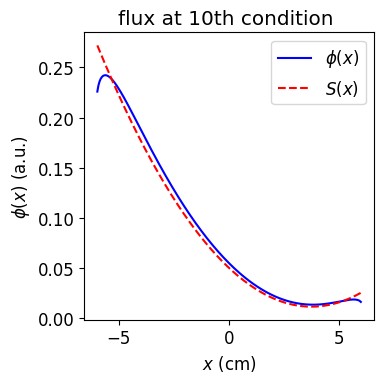

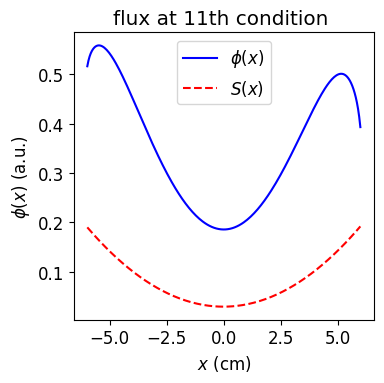

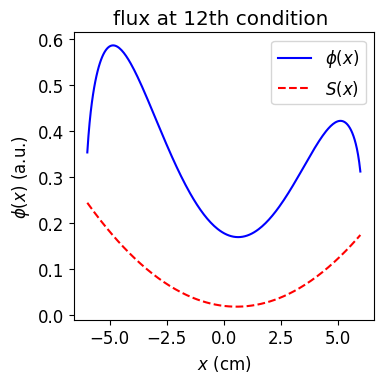

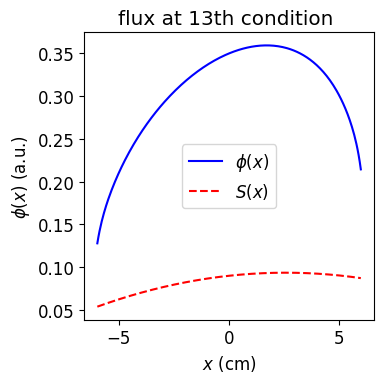

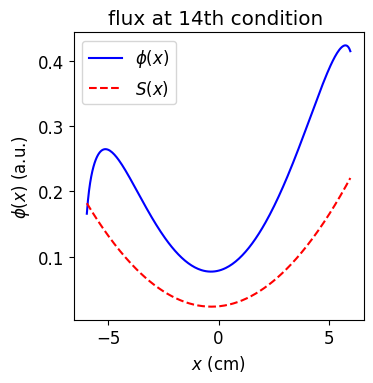

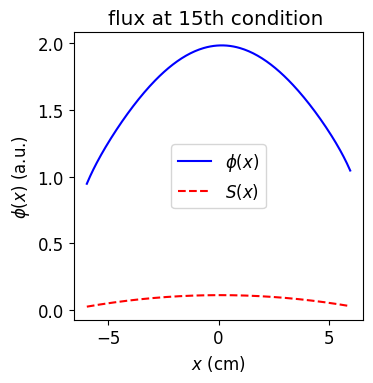

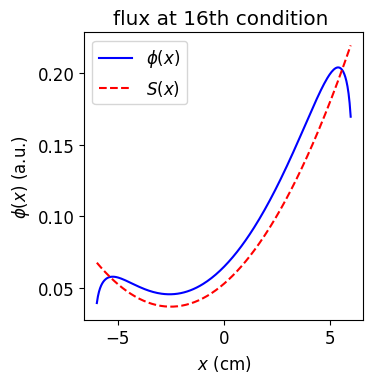

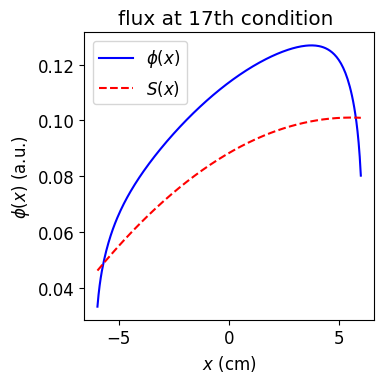

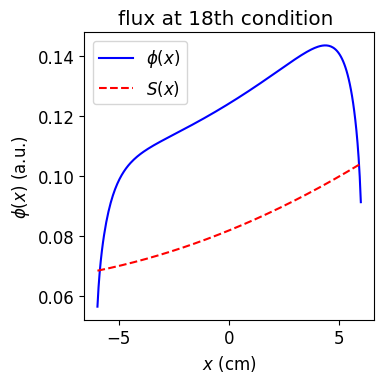

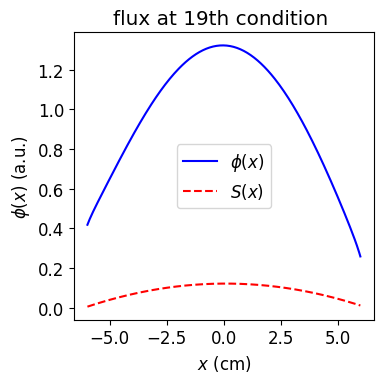

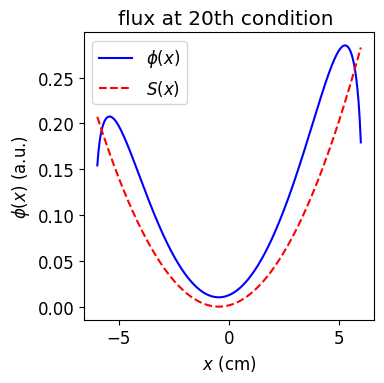

In [8]:
outermax = 1000
eps = 1e-12
np.random.seed(20240619)

LengthX = 12.0
NX = 240
dx = np.full( NX, LengthX/NX )
xS = np.linspace(start=-LengthX/2, stop=LengthX/2, num=NX+1)
x = (xS[:-1] + xS[1:])/2

matid = np.zeros(NX, dtype=np.int64)
NM, mu, mubound, w = setQuadrature(2*8, 1)

NC = 20
snapshotF = np.zeros( (NX,NC) )
snapshotQ = np.zeros( (NX,NC) )

plt.rcParams["figure.figsize"]=(4,4)
plt.rcParams["font.size"] = 12

for i in range(NC):
    SigA = np.random.uniform(low=0.01, high=1.0, size=(1))
    SigS = np.random.uniform(low=0.01, high=1.0, size=(1))

    s = np.zeros(NX)
    xi = np.random.uniform(low=-1.0, high=1.0)
    y = np.random.uniform(low=0.0, high=1.0, size=3)
    a = y[0]/(2*(1+xi)) +y[1]/(xi*xi-1) + y[2]/(2*(1-xi))
    b = (y[2]-y[0])/2
    c = xi*( y[0]/(2*(1+xi)) -y[2]/(2*(1-xi)) )  -y[1]/(xi*xi-1)
    vx = -b/(2*a)
    if vx>=-1 and vx<=1:
        vy = a*vx**2 + b*vx + c
        if vy <0:
            c = c-vy
            vy = vy = a*vx**2 + b*vx + c
            c = c-vy
    stotal = ((a/3)+c)*LengthX
    a = a/stotal
    b = b/stotal
    c = c/stotal

    s = a*(x/(LengthX/2))**2 + b*(x/(LengthX/2)) + c
    if s.min() < 0:
        print("Warning: source is negative")

    albedo = np.random.uniform(low=0.0, high=1.0, size=(2))

    flux = calcFluxMOC(SigS, SigA, s, dx, matid, albedo, w, mu, eps, outermax)
    snapshotF[:,i] = flux
    snapshotQ[:,i] = (s + SigS[matid]*flux)

    #if i>=10:
    #    continue

    plt.plot(x, flux, color="blue", linestyle="solid", label="$\phi(x)$")
    plt.plot(x, s, color="red", linestyle="dashed", label="$S(x)$")
    plt.title("flux at {} condition ".format(ordinal(i+1)))
    fluxmax = flux.max()
    #plt.ylim((0, fluxmax*1.1))
    plt.xlabel("$x$ (cm)")
    plt.ylabel("$\phi(x)$ (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()
